In [52]:
%matplotlib inline

import numpy as np
import control as ctl
from control.matlab import * 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from scipy import signal, linalg
from labellines import labelLine # pip install matplotlib-label-lines

# Note: in case of kernell crash when running control, update numpy

In [16]:
# set global plotting style
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

# plt.rc('font', **font)
plt.rcdefaults()

### Figure 1.6
Simulation of disk arm servo with analog (dashed) and computer control (solid). The sampling period is $h=0.2/\omega_0$.

In [2]:
freq = 1.
J = 4. # Moment of inertia of disk-drive
k = 3. # constant

a = 2.*freq
b = freq/2.
K = 2.*J*freq**2./k

G = ctl.tf([k],[J,0,0])
FB = K*ctl.tf([1, b], [1, a])
loop = ctl.feedback(G,FB,sign=-1)

gain = b*K/a


        3 z + 6
-----------------------
4 z^3 + 8 z^2 + 8 z + 4

dt = 0.1



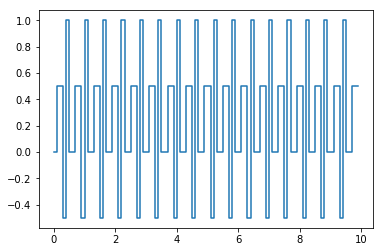

In [3]:
h = 0.1

G_d  = ctl.tf([k],[J,0,0],h)
FB_d = K*ctl.tf([1, b], [1, a],h)
loop_d = ctl.feedback(G_d,FB_d,sign=-1)

t_in = np.arange(0,10,h)
u_in = np.ones(len(t_in))*gain
# loop_d = loop.sample(h)
T, yout, xout = ctl.forced_response(loop_d, t_in, u_in)
yout = yout[0]
plt.step(T, yout)
print(loop_d)


In [18]:
dt = 0.01
t_in = np.arange(0,10,dt)
u = np.ones(len(t_in))*gain

t_out, y_out, _ = ctl.forced_response(loop, t_in, u)
_, e_out, _ = ctl.forced_response(FB, t_in, y_out)
error = u - e_out

In [22]:

    
def plot_discrete(h):
    fig1, axs = plt.subplots(num=1,nrows=2, ncols=1, figsize=(9,7))
    axs = np.asarray(axs).reshape(-1)
    loop_d = loop.sample(h)
    FB_d = FB.sample(h)

    td_in = np.arange(0,10,h)
    ud = np.ones(len(td_in))*gain

    td_out, yd_out, _ = ctl.forced_response(loop_d, td_in, ud)
    yd_out = yd_out[0] # discrete systems are stored as an array 
    _, ed_out, _ = ctl.forced_response(FB_d, td_in, yd_out)
    errord = ud - ed_out[0]
    fig1.show()
    
    # plot lti
    axs[0].step(t_out,y_out, color='blue')
    axs[1].step(t_out,error, color='blue')
    # plot discrete
    axs[0].step(td_out,yd_out, color='red')
    axs[1].step(td_out,errord, color='red')
    plt.show()
    
interactive_plot = interactive(plot_discrete, h=(0.1, 1.0))
interactive_plot

### Figure 1.8

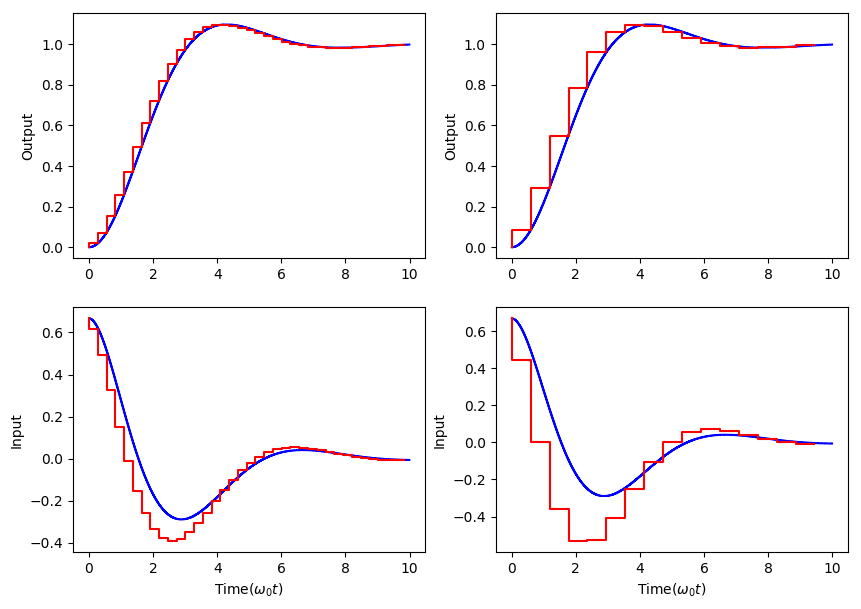

In [21]:
fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

h_range = [0.5, 1.08]
for i in range(2):
    h = h_range[i]/freq
    loop_d = loop.sample(h)
    FB_d = FB.sample(h)

    td_in = np.arange(0,10,h)
    ud = np.ones(len(td_in))*gain

    td_out, yd_out, _ = ctl.forced_response(loop_d, td_in, ud)
    yd_out = yd_out[0] # discrete systems are stored as an array 
    _, ed_out, _ = ctl.forced_response(FB_d, td_in, yd_out)
    errord = ud - ed_out[0]
    
    # plot lti
    axs[0][i].step(t_out,y_out, color='blue')
    axs[0][i].set_ylabel('Output')
    axs[1][i].step(t_out,error, color='blue')
    axs[1][i].set_ylabel('Input')
    # plot discrete
    axs[0][i].step(td_out,yd_out, color='red')
    axs[0][i].set_ylabel('Output')    
    axs[1][i].step(td_out,errord, color='red')
    axs[1][i].set_ylabel('Input')
    axs[1][i].set_xlabel('Time($\omega_0t$)')
    
plt.show();

### Figure 1.9

# Chapter 2

Consider the continuous-time system

$$
\frac{\omega_0^2}{s^2+2\zeta\omega_0s +\omega_0^2}
$$

The poles of the corresponding discrete-time system are given by the characteristic equation 

$$
z^2 + a_1z +a_2 = 0
$$
where 
$$
a_1 = -2e^{-\zeta\omega_0h}cos(\sqrt{1-\zeta^2}\omega_0h)\\
a_2 = e^{-2\zeta\omega_0h}
$$


#### Figure 2.7

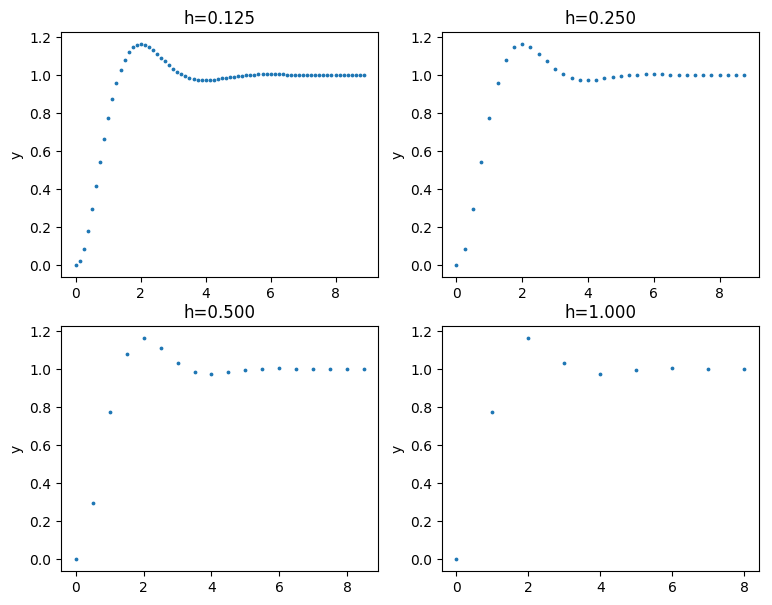

In [20]:
freq = 1.83
zeta = 0.5
h_range = [0.125, 0.25, 0.5, 1.0]

G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])


fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,7))
axs = np.asarray(axs).reshape(-1)

for i in range(4):
    dt = h_range[i]
    G_d = G.sample(dt)
    t_in = np.arange(0,9,dt)
    _, _y_out = ctl.step_response(G_d, t_in)
    
    y_step = _y_out[0] # output is stored in tuple
    axs[i].scatter(t_in,y_step,3)
#     axs[i].grid()
#     axs[i].set_xlabel('t')
    axs[i].set_ylabel('y')
    axs[i].set_title('h=%.3f'%dt)
plt.show()

## Sampling a Continuous-Time State-Space System

Assume that the continuous-time system is given in the following state-space form:

$$
\frac{dx}{dt} = Ax(t) + Bu(t) \\
y(t) = Cx(t) + Du(t)
$$

A common situation in computer control is that the D-A converter is so constructed taht it holds the analog signal constant until a new conversion is commanded. This is often called a *zero-order-hold circuit*.

This can be expressed using the following mathematical equation:

$$
x(t_{k+1}) = \Phi(t_{k+1}, t_k)x(t_k) + \Gamma(t_{k+1},t_k)u(t_k) \\
y(t_k) = Cx(t_k) + Du(t_k)
$$

where

$$
\Phi(t_{k+1}, t_k) = e^{A(t_{k+1}-t_k)}\\
\Gamma(t_{k+1},t_k) = \int^{t_{k+1}t_k}_0e^{As}ds\ B
$$

The relationship between the sampled signals can be expressed by the linear difference equation shown above. notice that this equation does not involve any approximations. It gives the exact values of the state variables and the output at the sampling instants because the control signal is constant between the sampling instants. The model is therefore called a zero-roder-hold sampling of the system. \\
In most cases $D=0$. One reason for this is because in computer-controlled systems, the output y is first measured and the control signal $u(t_k)$ is then generated as a function of $y(t_k)$. In practice it often happens that there is a significant delay between the A-D and D-A conversions. However it is easy to make the necessary modifications. The state vector at times between sampling points is given by $x(t_{k+1})$. This makes it possible to investigate the intersample behavior of the system. Notice that the responses between the sampling points are parts of step respones, with initial conditions, for the system. This implies that the system is running in open loop between the sampling points.\\
For periodic sampling with period h, we have $t_k=k\cdoth and the model given above simplifies to the time-invariant system:

$$
x(kh+h) = \Phi (kh) + \Gamma (kh) \\
y(kh) = Cx(kh) + Du(kh)
$$

where 

$$
\Phi = e^{Ah} \\
\Gamma = \int_0^h e^{As}ds\ B
$$

From this it follows that

$$
\frac{d\Phi(t)}{dt}= A\Phi(t) = \Phi(t)A \\
\frac{d\Gamma(t)}{dt} = \Phi(t)B
$$

The matrices $\Phi$ and $\Gamma$ therefore satisfy the equation

$$
\frac{d}{dt} 
\begin{bmatrix}
\Phi(t) & \Gamma(t) \\
0 & I
\end{bmatrix}
=
\begin{bmatrix}
\Phi(t) & \Gamma(t) \\
0 & I
\end{bmatrix}
\begin{bmatrix}
A & B \\
0 & 0
\end{bmatrix}
$$
Where I is a unit matrix of the same dimension as the number of inputs. The matrices $\Phi(h)$ and $\Gamma(h)$ for the sampling period h therefore can be obtained from the block matrix:

$$
\begin{bmatrix}
\Phi(h) & \Gamma(h) \\
0 & I
\end{bmatrix}
=
exp(\begin{bmatrix}
A & B \\
0 & 0
\end{bmatrix}
h)
$$

## Python implementation

In [105]:
"""
This function calculates the Phi and Gamma values used for zero order hold and
the Pulse-Transfer operator.

@input ss_sys: expects a tuple of (A, B, C, D)
@input h: sampling period
@output Phi, Gamma
"""
def get_phi_gamma(ss_sys, h):
    # Using the formula shown above
    # create matrix [A B ;
    #                0 0]
    A, B, C, D = ss_sys
    m_top = np.hstack((A, B)) # create top of matrix
    m_bottom = np.zeros(m_top.shape) # create bottom part
    m = np.vstack((m_top, m_bottom)) # combine top and bottom 
    expm = linalg.expm(m*h)
    
    # Dispose of the lower rows
    expm = expm[:A.shape[0], :]

    Phi = expm[:, 0:A.shape[1]]
    Gamma = expm[:, A.shape[1]:]
    return (Phi, Gamma)


"""
This function converts a continuous-time state space system into
a discrete system with sampling period h using zero order hold.

@input ss_sys: expects a tuple of (A, B, C, D)
@input h: sampling period
@output ss_d: a tuple of (A, B, C, D)
"""
def zoh(ss_sys, h):
    Ad, Bd = get_phi_gamma(ss_sys, h)
    Cd = C
    Dd = D
    
    return (Ad, Bd, Cd, Dd)


### Example 2.2 Double integrator

The double integrator is described by

$$
\frac{dx}{dt} = 
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\
1
\end{bmatrix}
u \\
y = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
x
$$

Hence

$$
\Phi = e^{Ah} = I +Ah+\frac{A^2h^2}{2} + \ldots =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
+
\begin{bmatrix}
0 & h \\
0 & 0
\end{bmatrix}
=
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix} \\
\Gamma = \int_0^h 
\begin{bmatrix}
s \\
1
\end{bmatrix}
ds
=
\begin{bmatrix}
\frac{h^2}{2} \\
h
\end{bmatrix}
$$

The discrete-time model of the double integrator is

$$
x(kh+h) = 
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix}
x(kh) +
\begin{bmatrix}
\frac{h^2}{2} \\
h
\end{bmatrix}
u(kh) \\
y(kh) = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
x(kh)
$$

This can easily be done by the python function above:

In [108]:
# Example 2.2 (with )

h = 0.1
m = 30

A = np.array([[0, 1], [0, 0]])
B = np.array([[0, 0], [1./m, 0]])
C = np.array([[1, 0], [0, 0]])

Ad, Bd, Cd, Dd = zoh((A, B, C, D), h)
print("Ad="); print(Ad)
print("Bd="); print(Bd)
print("Cd="); print(Cd)

Ad=
[[1.  0.1]
 [0.  1. ]]
Bd=
[[0.00016667 0.        ]
 [0.00333333 0.        ]]
Cd=
[[1 0]
 [0 0]]


### The Pulse-Transfer Operator


$$
H(q) = C(qI-\Phi)^{-1}\Gamma + D = \frac{B(q)}{A(q)}
$$

In [104]:
from sympy import Symbol, Matrix, simplify


def pulse_transfer(ss_sys, h):
    A, B, C, D = ss_sys
    q = Symbol('q')
    Phi, Gamma = get_phi_gamma(ss_sys, h)
    m_inv = Matrix(q*np.eye(Phi.shape[0])-Phi).inv()
    H = C*m_inv*Gamma
    return H


### Example 2.12

In [103]:
A = np.array([[0, 1], [0, 0]])
B = np.array([[0, 0], [1., 0]])
C = np.array([[1, 0], [0, 0]])

H = pulse_transfer((A,B,C,D), 1.)

q = Symbol('q')
ans = 0.5*(q**-1+q**-2)/(1-2*q**-1+q**-2) 
print(simplify(H[0]))
# Zero check
print(simplify(H[0]-ans))

0.5*(q + 1)/(1.0*q**2 - 2.0*q + 1.0)
0


### Example 2.2 Double integrator

The double integrator is described by

$$
\frac{dx}{dt} = 
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\
1
\end{bmatrix}
u \\
y = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
x
$$

Hence

$$
\Phi = e^{Ah} = I +Ah+\frac{A^2h^2}{2} + \ldots =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
+
\begin{bmatrix}
0 & h \\
0 & 0
\end{bmatrix}
=
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix} \\
\Gamma = \int_0^h 
\begin{bmatrix}
s \\
1
\end{bmatrix}
ds
=
\begin{bmatrix}
\frac{h^2}{2} \\
h
\end{bmatrix}
$$

The discrete-time model of the double integrator is

$$
x(kh+h) = 
\begin{bmatrix}
1 & h \\
0 & 1
\end{bmatrix}
x(kh) +
\begin{bmatrix}
\frac{h^2}{2} \\
h
\end{bmatrix}
u(kh) \\
y(kh) = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
x(kh)
$$



### Complex poles

Consider the continuous-time system
$$
G = \frac{\omega^2}{s^2 + 2\zeta\omega_0s+\omega_0^2}
$$
The poles of the corresponding dicrete-time system are given by the characteristic equation:
$$
z^2+a_1z+a_2 = 0
$$
where
$$
a_1 = -2e^{-\zeta\omega_0h}cos(\sqrt{1-\zeta^2}\omega_0h \\
a_2 = e^{-2\zeta\omega_0h}
$$

In [11]:
freq = 1.83
zeta = 0.5
h = 0.1

G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
print("Continuous-time system G: ")
print(G)
print("The poles of the corresponding discrete-time system: ")
a_1 = -2*np.exp(-zeta*freq*h)*np.cos(np.sqrt(1-zeta**2)*freq*h)
a_2 = np.exp(-2*zeta*freq*h)
print("z^2 + %.3fz + %.3f = 0 \n" % (a_1, a_2))

print("We can use the built in sample function to confirm our solution:")
print(G.sample(h))

Continuous-time system G: 

        3.349
--------------------
s^2 + 1.83 s + 3.349

The poles of the corresponding discrete-time system: 
z^2 + -1.802z + 0.833 = 0 

We can use the built in sample function to confirm our solution:

  0.01572 z + 0.01479
----------------------
z^2 - 1.802 z + 0.8328

dt = 0.1



In [25]:
h = 0.1
freq = 1.83
zeta = 0.5

G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
G_d = G.sample(3)

# calculate for constant damping
sampling_rates = np.arange(0.01,1.8,0.05)
dampings = np.arange(0, 1.1, 0.1)
poles_cd = np.zeros((len(dampings),len(sampling_rates)),dtype=np.complex_)

for i,zeta in enumerate(dampings): # loop over damping ratios
    G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
    for j,h in enumerate(sampling_rates): # loop over sampling rates
        G_d = G.sample(h)
        _poles, _ = ctl.pzmap(G_d, Plot=False)
        poles_cd[i,j] = _poles[0] # only store one pole
        
# calculate for constant sampling rate
sampling_rates = np.arange(0.2,1.8,.2)
_dampings = np.arange(0, 1.1, 0.01)
poles_cs = np.zeros((len(sampling_rates),len(_dampings)),dtype=np.complex_)

for i,zeta in enumerate(_dampings): # loop over damping ratios
    G = ctl.tf([freq**2], [1, 2*zeta*freq, freq**2])
    for j,h in enumerate(sampling_rates): # loop over sampling rates
        G_d = G.sample(h)
        _poles, _ = ctl.pzmap(G_d, Plot=False)
        poles_cs[j,i] = _poles[0] # only store one pole

### Figure 2.8

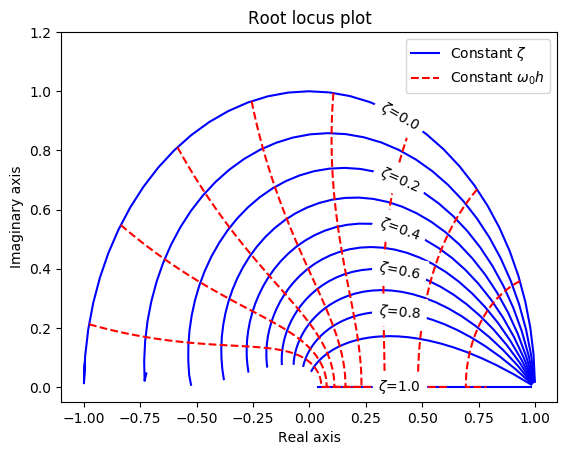

In [26]:
# note: we flip the arrays to allow for linelabelling since it assumes incremental data
lines = plt.plot(np.flip(poles_cd.T.real), np.flip(poles_cd.T.imag), 1, color='blue')
# lines = plt.plot(poles_cd.T.real, poles_cd.T.imag, color='blue')
plt.plot(poles_cs.T.real, poles_cs.T.imag, color='red', linestyle='--')
plt.ylim(top=1.2)
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.title('Root locus plot')

# set labels
for i, line in enumerate(lines[::2]):
    labelLine(line, 0.4, label="$\zeta$=%.1f" % dampings[i*2], color='black')
    
legend_elements = [plt.Line2D([0], [0], color='b', label='Constant $\zeta$'),
                   plt.Line2D([0], [0], color='r', linestyle='--', label='Constant $\omega_0h$')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()